In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/file-srt/Dataset srt/R/M3GAN.2022.1080p.WEB.H264-NAISU.srt
/kaggle/input/file-srt/Dataset srt/R/John.Wick.Chapter.3.Parabellum.2019.720p.BluRay.x264-.YTS.LT.-HI.srt
/kaggle/input/file-srt/Dataset srt/R/The.Voyeurs.2021.1080p.AMZN.WEB-DL.DDP5.1.H.264-CMRG-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Anora.2024.1080p.AMZN.WEB-DL.DDP5.1.H.264-FLUX.srt
/kaggle/input/file-srt/Dataset srt/R/The.Medium.2021.1080p.WEB-DL.x264.srt
/kaggle/input/file-srt/Dataset srt/R/Insidious.The.Red.Door.2023.720p.BluRay.x264.AAC.srt
/kaggle/input/file-srt/Dataset srt/R/Curse.of.the.Witchs.Doll.2018.HDRip.XviD.AC3-EVO-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Challengers.2024.1080p.AMZN.WEB-DL.DDP5.1.Atmos.H.264-FLUX.srt
/kaggle/input/file-srt/Dataset srt/R/A.Star.is.Born.2018.720p.BluRay.DD5.1.X264-iFT-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Fifty Shades Freed.2018.HDRip.XviD.AC3-EVO.srt
/kaggle/input/file-srt/Dataset srt/R/Destination.Wedding.2018.720p.BluRay.x264-VETO.srt
/kaggle/input/f


Jumlah data: 240
label
G        60
PG       60
PG-13    60
R        60
Name: count, dtype: int64

=== Cross-Validation (5-Fold) ===
Cross-validation scores: [0.72916667 0.54166667 0.70833333 0.625      0.58333333]
Mean CV Accuracy: 0.6375

=== Classification Report ===
              precision    recall  f1-score   support

           G     0.6364    0.5833    0.6087        12
          PG     0.5455    0.5000    0.5217        12
       PG-13     0.7692    0.8333    0.8000        12
           R     0.8462    0.9167    0.8800        12

    accuracy                         0.7083        48
   macro avg     0.6993    0.7083    0.7026        48
weighted avg     0.6993    0.7083    0.7026        48


=== Confusion Matrix ===


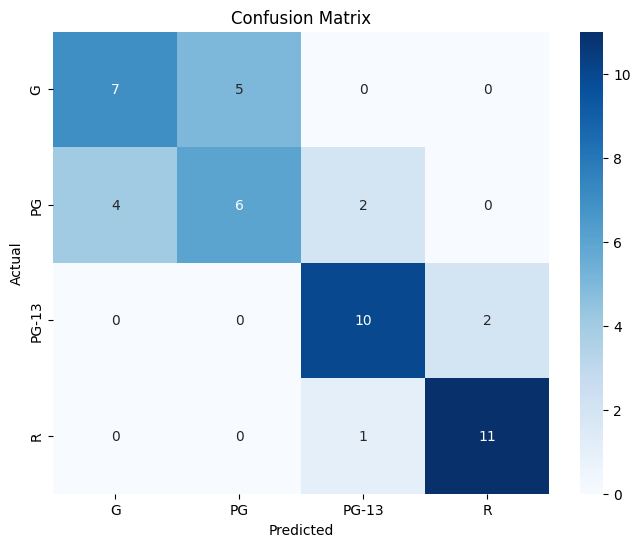


Test Set Accuracy: 0.7083
Saved: random_forest_fixed.pkl
Saved: random_forest_specific_params.pkl
Saved: tfidf_vectorizer.pkl


In [ ]:
import os
import re
import string
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def clean_subtitle(text):
    text = re.sub(r'\d{2}:\d{2}:\d{2},\d+ --> \d{2}:\d{2}:\d{2},\d+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    text = clean_subtitle(text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

def load_dataset(base_path, max_files_per_class=60):
    data = []
    labels = []
    categories = ['G', 'PG', 'PG-13', 'R']
    for label in categories:
        folder_path = os.path.join(base_path, label)
        if not os.path.exists(folder_path):
            continue
        count = 0
        for filename in os.listdir(folder_path):
            if count >= max_files_per_class:
                break
            if filename.endswith('.srt'):
                file_path = os.path.join(folder_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        raw_text = f.read()
                        if len(raw_text.strip()) > 0:
                            processed = preprocess_text(raw_text)
                            if len(processed.split()) > 10:
                                data.append(processed)
                                labels.append(label)
                                count += 1
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
    return pd.DataFrame({'text': data, 'label': labels})

def main(base_path):
    # Load data
    df = load_dataset(base_path)
    print(f"\nJumlah data: {len(df)}")
    print(df['label'].value_counts())

    vectorizer = TfidfVectorizer(max_features=62, min_df=5, max_df=0.6)

    rf_params = {
        'n_estimators': 25,
        'max_depth': 8,
        'min_samples_split': 10,
        'min_samples_leaf': 6,
        'class_weight': 'balanced',
        'random_state': 42
    }

    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', RandomForestClassifier(**rf_params))
    ])

    print("\n=== Cross-Validation (5-Fold) ===")
    cv_scores = cross_val_score(pipeline, df['text'], df['label'], cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, digits=4))

    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(y_test, y_pred)
    labels = ['G', 'PG', 'PG-13', 'R']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"\nTest Set Accuracy: {acc:.4f}")

    joblib.dump(pipeline, 'random_forest_fixed.pkl')
    print("Saved: random_forest_fixed.pkl")

    clf = pipeline.named_steps['classifier']
    vect = pipeline.named_steps['vectorizer']

    joblib.dump(clf, 'random_forest_specific_params.pkl')
    joblib.dump(vect, 'tfidf_vectorizer.pkl')

    print("Saved: random_forest_specific_params.pkl")
    print("Saved: tfidf_vectorizer.pkl")

# === RUN ===
if __name__ == '__main__':
    BASE_PATH = '/kaggle/input/file-srt/Dataset srt'
    main(BASE_PATH)

In [4]:
!zip -r randomforest_.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/tfidf_vectorizer.pkl (deflated 52%)
  adding: kaggle/working/random_forest_fixed.pkl (deflated 57%)
  adding: kaggle/working/random_forest_specific_params.pkl (deflated 80%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/random_forest_model.pkl (deflated 57%)


In [5]:
from IPython.display import FileLink
FileLink(r'randomforest_.zip')

/kaggle/working/randomforest_.zip